
# Tutorial on modelling synaptic plasticity

<br><center><big><a href="http://ruipcosta.weebly.com/">Rui Ponte Costa</a></big><br><small>University of Bern and University of Oxford<br>University of Bristol</small> <font size="1">(from August 2018)</font></center>
<p>

# 1. Short-term synaptic plasticity
As we discussed in the class, presynaptic action potentials trigger the <i>release of neurotransmitters</i> that bind to postsynaptic receptors, which elicits a postsynaptic response (see a recent review <a href="http://cshperspectives.cshlp.org/content/4/7/a005702.full">here</a>). If multiple presynaptic action potentials are triggered in quick succession, in most synapses we observe that the postsynaptic responses are quickly reduced in amplitude (<b>short-term synaptic depression</b>) or increased (<b>short-term synaptic facilitation</b>). This is a short-lasting effect of up to a few seconds. Here we will look at a mathematical model of short-term synaptic plasticity that captures <b>short-term depression</b>.

<br>
<figure>
    <img src='files/Figures/Synapse_STP.png' width="410" alt='Synapse with short-term synaptic plasticity (depression)' />
    <figcaption><b>Figure 1</b>: Schematic of synapse with short-term depression. The schematic represents the presynapse and neurotransmitter vesicles (blue) and the postsynapse with neurotransmitter receptors (red). Vertical blue lines represent presynaptic spikes. $P_{\mathrm{rel}}$ is the release probability, $R$ is the number of available release vesicles and $\tau_D$ is the timeconstant with which the vesicles are recycled. Red traces represent the postsynaptic voltage with excitatory postsynaptic potentials recorded from connection between pyramidal cells in the visual cortex of young mice (<a href="http://frontiersin.org/articles/10.3389/fncom.2013.00075/full">Costa et al. 2013</a>). </figcaption>
</figure>


## 1.1 A model of short-term depression

This notebook implements a simple <b>short-term plasticity</b> model based on the model first introduced by <a href="http://www.pnas.org/content/94/2/719">Tsodyks and Markram (1997) PNAS</a>. This model is defined by the following differential equations:
<br>
<center>
<font size="4">
$\begin{equation}
\frac{dR}{dt} = \frac{1-R}{\tau_D} - RP_r\delta_{\mathrm{spike}}
\end{equation}$
</font>
</center>

where $R$ represents the number of presynaptic vesicles, $\tau_D$ the depression timeconstant, $P_r$ the vesicle release probability (also called Utilization Factor) and $\delta_{\mathrm{spike}}$ represents the presynaptic spike. It can be implemented as (i.e. <a href="http://en.wikipedia.org/wiki/Euler_method">Euler method</a>):
<br>
```python
dR = (1-R)/tau_D - R*P_r*spikes
R = R + dt*dR
```

The postsynaptic input is given by $q \times R \times P_r$, where $q$ is the postsynaptic (<i>quantal</i>) amplitude factor which models the number of postsynaptic receptors.

We model the postsynaptic neuron as a passive neuron (i.e. no spikes and with only a membrane timeconstant) $\frac{dVm}{dt} = \frac{-Vm}{\tau_mem} - ARU\delta_{\mathrm{spike}}$

```python
dVm = -Vm[t]/tau_mem + q*R*P_r*spikes
Vm[t+1] = Vm[t] + dt*dVm
```

## 1.2 Playing with the model

### 1.2.1 Run the model

You are using a Python notebook, which is divided into cells. To run the Tsodyks-Markram STD model you need to select the next cell (by clicking on it) and then pressing SHIFT+ENTER. This will generate a figure at the end of the cell.

### 1.2.2 Understand the role of the different parameters

The Tsodyks-Markram STD model has three parameters: the release probability (or utilization factor) $U$, the depression timeconstant $\tau_D$ and an amplitude factor $A$. Their values are defined in the following lines:
```python
q = 2 #Postsynatic amplitude (~ number of postsynaptic receptors)
P_r = 0.7 #Release probability
tau_D = 100 #Depression timeconstant (ms)
```
and the $\tau_mem$ is the postsynaptic membrane timeconstant
```python
tau_mem = 100 #Membrane timeconstant (ms)
```

Change the values of these variables and run the model to better understand their impact. For example, what is the impact of setting `tau_D = 200` or `tau_D = 20`?

### 1.2.3 Change the presynaptic spike frequency

The effect of short-term plasticity is frequency-dependent, and becomes more prominent at higher frequencies. Try changing the variable `pre_rate` to 0.1 Hz, what happens? What would you expect to happen if you now set it to 100 Hz?

## 1.3 Fitting the model to an experiment

See below.

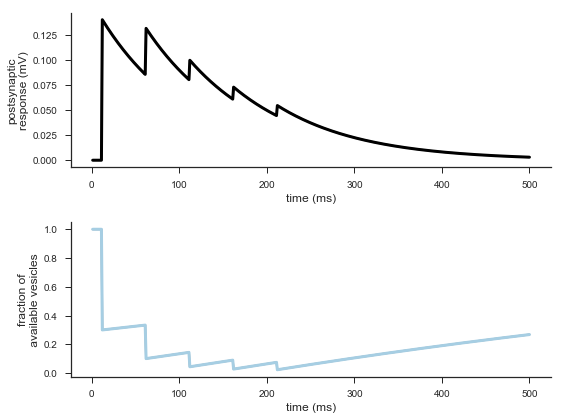

In [201]:
# Python code for the short-term depression model described above

# Import modules
import code
import math
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
plt.rc('axes', labelsize=12)
colorp = "Paired"
colors = sns.color_palette(colorp,10)
sns.set_palette(colorp,10)

# -- Parameters: begin --#
q = 2 #Postsynatic amplitude (~ number of postsynaptic receptors)
P_r = 0.7 #Release probability
tau_D = 100 #Depression timeconstant (ms)
pre_rate = 20 #presynaptic spikes per second (Hz)
# -- Parameters: end --#

# Setup simulation    
tau_mem = 10 #Membrane timeconstant (ms)
nspikes = 5

simtime = 500


R = np.ones((simtime,1)) #Number of vesicles
Vm = np.zeros((simtime,1)) #Postsynaptic voltage
spikes = np.zeros((simtime,1)) #Spike train

interval = (1000/pre_rate)
last = interval*nspikes+10
spikes[10:last:interval] = 1
dt = 0.1


for t in range(1,simtime-1):
    dVm = -Vm[t]/tau_mem + q*R[t]*P_r*spikes[t]
    Vm[t+1] = Vm[t] + dt*dVm
    
    dR = (1-R[t])/tau_D - P_r*R[t]*spikes[t]/dt
    R[t+1] = R[t] + dt*dR


fig = plt.figure(figsize=(8, 6))

lw = 3
nrows = 2
ncols = 2

#A: Postsynaptic responses
ax_A = plt.subplot2grid((nrows,ncols), (0, 0), colspan=2)

linear_fun = np.arange(1,simtime+1)

VmO = np.fromfile('STD_original.dat', dtype=float)

ax_A.plot(linear_fun, VmO, label='original', linewidth=lw-1, color='gray')
ax_A.plot(linear_fun, Vm, label='new', linewidth=lw, color='black')
ax_A.set(xlabel='time (ms)', ylabel='postsynaptic\nresponse (mV)')
if Vm[50]!=VmO[50]:
    ax_A.legend(fontsize=12, loc='upper right')

#B: Presynaptic vesicles
ax_B = plt.subplot2grid((nrows,ncols), (1, 0), colspan=2)

RO = np.fromfile('STD_R_original.dat', dtype=float)
ax_B.plot(linear_fun, RO, label='original', linewidth=lw-1, color='gray')
ax_B.plot(linear_fun, R, label='new', linewidth=lw)
ax_B.set(xlabel='time (ms)', ylabel='fraction of\n available vesicles ')#, xlim=(0,30), ylim=(-5,30))

if R[50]!=RO[50]:
    ax_B.legend(fontsize=12, loc='upper right')
    
sns.despine()

plt.tight_layout()
plt.show()

## 1.3 Fitting model to experiment

Now you will try to manually fit the parameters of the model to a real experiment. You will need to adjust all four parameters ($q$, $P_r$, $\tau_D$ and 'pre_rate') to match the model (black line in Figure 2) to the experimental-like data (red line in Figure 2). 
<br>
<figure>
    <img src='files/Figures/PCPC_mock_recording.png' width="510" alt='Short-term depression at pyramidal cell synapses' />
    <figcaption><b>Figure 2</b>: Experiment (red) and model (black) of short-term depression. The experimental data is based on short-term depression observed at excitatory synapses between pyramidal-to-pyramidal cells in layer-5 of visual cortex in young mice (<a href="http://frontiersin.org/articles/10.3389/fncom.2013.00075/full">Costa et al. 2013</a>). </figcaption>
</figure>

In practice you would be doing this using an automatic optimization method that finds the parameters that  minimize the difference between the model and the data. However this approach might give you a poor understanding of the landscape of possible parameters, for this reason sampling methods have recently been introduced (e.g. <a href="http://frontiersin.org/articles/10.3389/fncom.2013.00075/full">Costa et al. 2013</a> and <a href="http://www.frontiersin.org/articles/10.3389/fncom.2016.00116/full">Bird et al. 2016</a>)

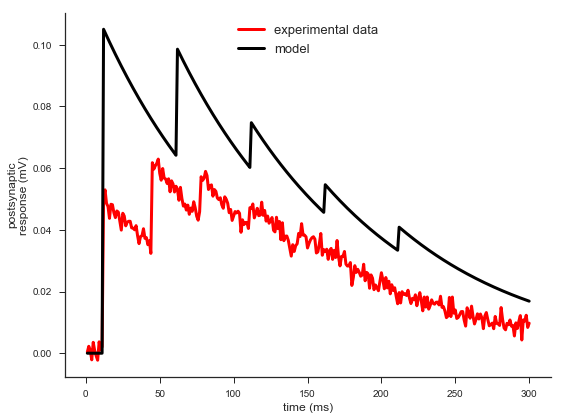

In [202]:
#-- Parameters: begin --#
q = 1.5 #Postsynatic amplitude (~ number of postsynaptic receptors)
P_r = 0.7 #Release probability
tau_D = 100 #Depression timeconstant (ms)
pre_rate = 20 #presynaptic spikes per second (Hz)
#-- Parameters: end --#

tau_mem = 10 #Membrane timeconstant (ms)
nspikes = 5 #Number of spikes
simtime = 300

R = np.ones((simtime,1)) #Number of vesicles
Vm = np.zeros((simtime,1)) #Postsynaptic voltage
spikes = np.zeros((simtime,1)) #Spike train

interval = (1000/pre_rate)
last = interval*nspikes+10
spikes[10:last:interval] = 1
#print(spikes)
dt = 0.1


for t in range(1,simtime-1):
    dVm = -Vm[t]/tau_mem + q*R[t]*P_r*spikes[t]
    Vm[t+1] = Vm[t] + dt*dVm
    
    dR = (1-R[t])/tau_D - P_r*R[t]*spikes[t]/dt
    R[t+1] = R[t] + dt*dR


fig = plt.figure(figsize=(8, 6))

lw = 3
nrows = 1
ncols = 2

#A: Postsynaptic responses
ax_A = plt.subplot2grid((nrows,ncols), (0, 0), colspan=2)

linear_fun = np.arange(1,simtime+1)

data = np.fromfile('data_STD_PCPC.dat', dtype=float)

ax_A.plot(linear_fun, data, label='experimental data', linewidth=lw, color='red')
ax_A.plot(linear_fun, Vm, label='model', linewidth=lw, color='black')
ax_A.set(xlabel='time (ms)', ylabel='postsynaptic\nresponse (mV)')#, xlim=(0,30), ylim=(-5,30))
ax_A.legend(fontsize=13, loc='upper center')

sns.despine()

plt.tight_layout()

plt.show()

# 2. Modelling spike-timing-dependent plasticity (STDP)

Here we will study the most simple model of spike-timing-dependent plasticity (STDP, Figure 3). In contrast to short-term plasticity, STDP leads to changes in the synaptic weight that last for <i>one hour or more</i>. STDP was first predicted by <a href="https://www.nature.com/articles/383076a0">Gerstner et al. 1996 Nature</a> and later confirmed by <a href="https://www.ncbi.nlm.nih.gov/pubmed/8985014">Markram et al. 1997 Science</a>. 
<br>
<br>
<figure>
    <img src='files/Figures/STDP.png' width="410" alt='Spike-timing-dependent plasticity' />
    <figcaption><center><b>Figure 3</b>: Schematic of spike-timing-dependent plasticity (STDP). In STDP if  neuron $A$ fires before neuron $B$ it yields long-term potentiation (i.e. an increase in the synaptic weight; green). If neuron $A$ fires before $B$ long-term depression is observed (i.e. a decrease in the synaptic weight; red). $\Delta t$ is equal to the time of the presynaptic spikes minus the time of the postsynaptic spikes ($\mathrm{pre}_{\mathrm{timing}}-\mathrm{post}_{\mathrm{timing}}$). $\Delta W$ represents the change in the synaptic weight.</center></figcaption>
</figure>

The most simple STDP model is captured by two exponentials (Figure 3, bottom right):
<br>
<font size="4">
<center>
If $\Delta t>0$: 
$\begin{equation}
\Delta W = -A_{\mathrm{LTD}}\exp(-\frac{\Delta t}{\tau_{\mathrm{LTD}}})
\end{equation}$
</center>
<br>
<center>
If $\Delta t\leq0$: 
$\begin{equation}
\Delta W = A_{\mathrm{LTP}}\exp(\frac{\Delta t}{\tau_{\mathrm{LTP}}})
\end{equation}$
</font>
</center>
<br>
where $\Delta t$ is equal to the time of the presynaptic spikes minus the time of the postsynaptic spikes ($\mathrm{pre}_{\mathrm{timing}}-\mathrm{post}_{\mathrm{timing}}$), and $\Delta W$ gives the change in the synaptic weight.


## 2.1 Playing with the STDP model

Change the different parameters ($A_{\mathrm{LTD}}$, $A_{\mathrm{LTP}}$, $\tau_{\mathrm{LTD}}$ and  $\tau_{\mathrm{LTP}}$) of the model to understand how they modify the STDP window.

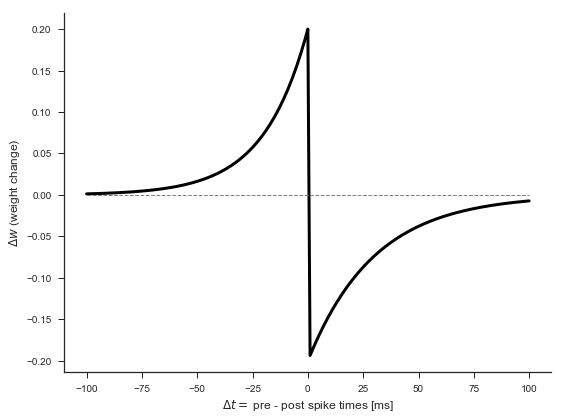

In [203]:
#-- Parameters: begin --#
A_LTD = 0.2 #LTD Amplitude factor 
A_LTP = 0.2 #LTP Amplitude factor 
tau_LTD = 30.0 #LTD decay
tau_LTP = 20.0 #LTP decay
#-- Parameters: end --#

ttime = 100
deltaWs = np.zeros((ttime*2+1,1))

c = 0
for deltat in range(-ttime,ttime+1):
    if(deltat>0):
        deltaWs[c] = -A_LTD*np.exp(-deltat/tau_LTD)
    else:
        deltaWs[c] = A_LTP*np.exp(deltat/tau_LTP)
    c = c+1
    
fig = plt.figure(figsize=(8, 6))

lw = 3
nrows = 1
ncols = 2

#A: Deltaw vs deltat responses
ax_A = plt.subplot2grid((nrows,ncols), (0, 0), colspan=2)

linear_fun = np.arange(-ttime,ttime+1)

#ax_A.plot(linear_fun, data, label='experimental data', linewidth=lw, color='red')
ax_A.plot(linear_fun, deltaWs, label='model', linewidth=lw, color='black')
ax_A.plot([-ttime, ttime], [0,0], linewidth=1, linestyle='dashed', color='gray')
ax_A.set(xlabel='$\Delta t =$ pre - post spike times [ms]', ylabel='$\Delta w$ (weight change)')
#ax_A.yaxis.label.set_size(40)

sns.despine()

plt.tight_layout()

plt.show()


## 2.2 Compute synaptic weight change

This is an extra exercise that requires that you do some coding in Python. Here you will calculate the change in the synaptic weights given a pre and a postsynaptic spike train. Part of the code is already written below. Use the presynaptic spike times in `pre_spike_times`, the postsynaptic spike times in `post_spike_times` and the `STDP` function defined below to calculate the total synaptic weight change given STDP as implemented above.
<br>
<br>
What is the total synaptic weight modification that you obtain with the given pre and postsynaptic spike trains?

In [204]:
nspikes = 5
delay = 10
rate = 20

interval = (1000/rate)

last_spike = interval*nspikes+delay
pre_spike_times = range(delay,last_spike,interval)

deltatime = 10
last = interval*nspikes+delay+deltatime
post_spike_times = range(delay+deltatime,last_spike,interval)

def STDP(deltat):
    if(deltat>0):
        return -A_LTD*np.exp(-deltat/tau_LTD)
    else:
        return A_LTP*np.exp(deltat/tau_LTP)

#Write remaining code here

# 3 More

These (and other) synaptic plasticity models can then be used to make functional predictions at the single neuron and/or neural network level. If you want to explore more models and functions of synaptic plasticity, I suggest that you look into these papers/resources:
<br>
 - http://www.scholarpedia.org/article/Spike-timing_dependent_plasticity
 - Costa RP, Froemke RC, Sjöström PJ, & van Rossum MC (2015). Unified pre- and postsynaptic long-term plasticity enables reliable and flexible learning. eLife, 4 (modelling: pre- and postsynaptic expression of STDP, which also includes STP)
 - LF Abbott, WG Regehr (2004) - Synaptic computation, Nature 431 (modelling and experimental review on multiple timescales of synaptic plasticity
 - Markram H, Gerstner W, & Sjöström PJ (2011). A history of spike-timing-dependent plasticity. Frontiers in Synaptic Neuroscience, 3. (historical perspective on STDP)
 - Markram H, & Tsodyks M (1996). Redistribution of synaptic efficacy between neocortical pyramidal neurons. Nature. (Experimental paper on the interaction of short-term synaptic plasticity and STDP)
 - Sjöström PJ, Turrigiano GG, & Nelson SB (2001). Rate, Timing, and Cooperativity Jointly Determine Cortical Synaptic Plasticity. Neuron, 32(6), 1149–1164. (Detailed exploration of STDP)


### Acnowledgments

I would like to thank Milton Llera for his feedback.
